<a href="https://colab.research.google.com/github/subikkshas/DA6400/blob/main/PA1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gymnasium
!pip install matplotlib
!pip install wandb

In [ ]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import wandb

MountainCar-v0 Environment

In [ ]:
env = gym.make('MountainCar-v0', render_mode='human')
print("Observation Space:", env.observation_space)
print("Action Space:", env.action_space)

Observation Space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Action Space: Discrete(3)


In [ ]:
state = env.reset(seed=42)
print("Initial State:", state)  # Should be in the range [-0.6, -0.4] for position, 0 for velocity

Initial State: (array([-0.4452088,  0.       ], dtype=float32), {})


In [ ]:
env.render()

In [ ]:
# Discretize the state space
def discretize_state(state, bins):
    return tuple(np.digitize(s, b) - 1 for s, b in zip(state, bins))

# Initialize the Q-table
def initialize_q_table(state_space, action_space):
    return np.zeros(state_space + (action_space,))

In [ ]:
# Epsilon-greedy policy
def epsilon_greedy_policy(q_table, state, epsilon, action_space):
    if np.random.rand() < epsilon:
        return np.random.choice(action_space)  # Explore
    else:
        return np.argmax(q_table[state])  # Exploit

# Softmax policy
def softmax_policy(q_table, state, temperature, action_space):
    probabilities = np.exp(q_table[state] / temperature)
    probabilities /= np.sum(probabilities)  # Normalize to probabilities
    return np.random.choice(action_space, p=probabilities)

In [ ]:
# SARSA algorithm
def sarsa(env, num_episodes, alpha, gamma, epsilon, bins, max_steps=200, seed=None):
    if seed is not None:
        np.random.seed(seed)
        env.reset(seed=seed)

    # Discretize the state space
    state_space = (len(bins[0]), len(bins[1]))
    action_space = env.action_space.n
    q_table = initialize_q_table(state_space, action_space)

    # Track rewards for plotting
    rewards = []

    for episode in range(num_episodes):
        # Manually set the initial state: position is random, velocity is 0
        initial_position = np.random.uniform(-0.6, -0.4)  # Random position near the bottom
        initial_velocity = 0.0  # Starting velocity is always 0
        state = env.reset(options={'initial_state': (initial_position, initial_velocity)})[0]
        state = discretize_state(state, bins)
        action = epsilon_greedy_policy(q_table, state, epsilon, action_space)
        total_reward = 0

        for step in range(max_steps):
            # Take action and observe next state and reward
            next_state, reward, done, truncated, _ = env.step(action)
            next_state = discretize_state(next_state, bins)

            # Choose next action using epsilon-greedy policy
            next_action = epsilon_greedy_policy(q_table, next_state, epsilon, action_space)

            # SARSA update rule
            q_table[state][action] += alpha * (
                reward + gamma * q_table[next_state][next_action] - q_table[state][action]
            )

            # Update state and action
            state, action = next_state, next_action
            total_reward += reward

            if done or truncated:
                break

        rewards.append(total_reward)
        if (episode + 1) % 100 == 0:
            print(f"Seed {seed}, Episode {episode + 1}, Total Reward: {total_reward}")

    return rewards

In [ ]:
# Q-learning algorithm with Softmax
def q_learning(env, num_episodes, alpha, gamma, temperature, bins, max_steps=200, seed=None):
    if seed is not None:
        np.random.seed(seed)
        env.reset(seed=seed)

    # Discretize the state space
    state_space = (len(bins[0]), len(bins[1]))
    action_space = env.action_space.n
    q_table = initialize_q_table(state_space, action_space)

    # Track rewards for plotting
    rewards = []

    for episode in range(num_episodes):
        # Manually set the initial state: position is random, velocity is 0
        initial_position = np.random.uniform(-0.6, -0.4)  # Random position near the bottom
        initial_velocity = 0.0  # Starting velocity is always 0
        state = env.reset(options={'initial_state': (initial_position, initial_velocity)})[0]
        state = discretize_state(state, bins)
        total_reward = 0

        for step in range(max_steps):
            # Choose action using Softmax policy
            action = softmax_policy(q_table, state, temperature, action_space)

            # Take action and observe next state and reward
            next_state, reward, done, truncated, _ = env.step(action)
            next_state = discretize_state(next_state, bins)

            # Q-learning update rule
            best_next_action = np.argmax(q_table[next_state])
            q_table[state][action] += alpha * (
                reward + gamma * q_table[next_state][best_next_action] - q_table[state][action]
            )

            # Update state
            state = next_state
            total_reward += reward

            if done or truncated:
                break

        rewards.append(total_reward)
        if (episode + 1) % 100 == 0:
            print(f"Q-learning - Seed {seed}, Episode {episode + 1}, Total Reward: {total_reward}")

    return rewards

In [ ]:
def wandb_train():
    wandb.init(project="MountainCar-RL", entity="subikksha")
    config = wandb.config
    wandb.run.name = f"alpha_{config.alpha}_eps_{config.epsilon}_temp_{config.temperature}_bins_{config.num_bins}"
    env = gym.make('MountainCar-v0')

    bins = [
        np.linspace(-1.2, 0.6, config.num_bins),
        np.linspace(-0.07, 0.07, config.num_bins)
    ]

    # SARSA
    rewards_sarsa = sarsa(env, config.num_episodes, config.alpha, config.gamma, config.epsilon, bins, config.max_steps, seed=42)
    avg_return_sarsa = np.mean(rewards_sarsa[-100:])

    # Q-learning
    rewards_q = q_learning(env, config.num_episodes, config.alpha, config.gamma, config.temperature, bins, config.max_steps, seed=42)
    avg_return_q = np.mean(rewards_q[-100:])

    wandb.log({"avg_return_sarsa": avg_return_sarsa, "avg_return_q_learning": avg_return_q})

# Sweep Configuration
sweep_config = {
    "method": "random",
    "metric": {"name": "avg_return_sarsa", "goal": "maximize"},
    "parameters": {
        "alpha": {"values": [0.05, 0.1, 0.15, 0.2]},
        "epsilon": {"values": [0.01, 0.05, 0.1, 0.2]},
        "temperature": {"values": [0.2, 0.5, 1.0]},
        "num_bins": {"values": [15, 20, 25]},
        "gamma": {"value": 0.99},
        "num_episodes": {"value": 5000},
        "max_steps": {"value": 200}
    }
}

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="MountainCar-RL")
wandb.agent(sweep_id, wandb_train, count=20)

Create sweep with ID: cppzkh1g
Sweep URL: https://wandb.ai/subikksha-indian-institute-of-technology-madras/MountainCar-RL/sweeps/cppzkh1g


wandb: Agent Starting Run: vzzs1hrg with config:
wandb: 	alpha: 0.2
wandb: 	epsilon: 0.01
wandb: 	gamma: 0.99
wandb: 	max_steps: 200
wandb: 	num_bins: 20
wandb: 	num_episodes: 5000
wandb: 	temperature: 0.5


Seed 42, Episode 100, Total Reward: -200.0
Seed 42, Episode 200, Total Reward: -200.0
Seed 42, Episode 300, Total Reward: -200.0
Seed 42, Episode 400, Total Reward: -200.0
Seed 42, Episode 500, Total Reward: -200.0
Seed 42, Episode 600, Total Reward: -200.0
Seed 42, Episode 700, Total Reward: -200.0
Seed 42, Episode 800, Total Reward: -160.0
Seed 42, Episode 900, Total Reward: -200.0
Seed 42, Episode 1000, Total Reward: -176.0
Seed 42, Episode 1100, Total Reward: -200.0
Seed 42, Episode 1200, Total Reward: -193.0
Seed 42, Episode 1300, Total Reward: -200.0
Seed 42, Episode 1400, Total Reward: -200.0
Seed 42, Episode 1500, Total Reward: -175.0
Seed 42, Episode 1600, Total Reward: -163.0
Seed 42, Episode 1700, Total Reward: -166.0
Seed 42, Episode 1800, Total Reward: -166.0
Seed 42, Episode 1900, Total Reward: -156.0
Seed 42, Episode 2000, Total Reward: -157.0
Seed 42, Episode 2100, Total Reward: -200.0
Seed 42, Episode 2200, Total Reward: -200.0
Seed 42, Episode 2300, Total Reward: -200

avg_return_q_learning,▁
avg_return_sarsa,▁
avg_return_q_learning,-153.75
avg_return_sarsa,-167.92


wandb: Agent Starting Run: 1zqyx1so with config:
wandb: 	alpha: 0.1
wandb: 	epsilon: 0.05
wandb: 	gamma: 0.99
wandb: 	max_steps: 200
wandb: 	num_bins: 25
wandb: 	num_episodes: 5000
wandb: 	temperature: 0.2


Seed 42, Episode 100, Total Reward: -200.0
Seed 42, Episode 200, Total Reward: -200.0
Seed 42, Episode 300, Total Reward: -200.0
Seed 42, Episode 400, Total Reward: -200.0
Seed 42, Episode 500, Total Reward: -200.0
Seed 42, Episode 600, Total Reward: -200.0
Seed 42, Episode 700, Total Reward: -200.0
Seed 42, Episode 800, Total Reward: -200.0
Seed 42, Episode 900, Total Reward: -200.0
Seed 42, Episode 1000, Total Reward: -200.0
Seed 42, Episode 1100, Total Reward: -200.0
Seed 42, Episode 1200, Total Reward: -200.0
Seed 42, Episode 1300, Total Reward: -200.0
Seed 42, Episode 1400, Total Reward: -200.0
Seed 42, Episode 1500, Total Reward: -200.0
Seed 42, Episode 1600, Total Reward: -200.0
Seed 42, Episode 1700, Total Reward: -200.0
Seed 42, Episode 1800, Total Reward: -200.0
Seed 42, Episode 1900, Total Reward: -200.0
Seed 42, Episode 2000, Total Reward: -165.0
Seed 42, Episode 2100, Total Reward: -200.0
Seed 42, Episode 2200, Total Reward: -198.0
Seed 42, Episode 2300, Total Reward: -200

avg_return_q_learning,▁
avg_return_sarsa,▁
avg_return_q_learning,-175.94
avg_return_sarsa,-160.67


wandb: Agent Starting Run: h35z9bpn with config:
wandb: 	alpha: 0.15
wandb: 	epsilon: 0.1
wandb: 	gamma: 0.99
wandb: 	max_steps: 200
wandb: 	num_bins: 20
wandb: 	num_episodes: 5000
wandb: 	temperature: 1


Seed 42, Episode 100, Total Reward: -200.0
Seed 42, Episode 200, Total Reward: -200.0
Seed 42, Episode 300, Total Reward: -200.0
Seed 42, Episode 400, Total Reward: -200.0
Seed 42, Episode 500, Total Reward: -200.0
Seed 42, Episode 600, Total Reward: -200.0
Seed 42, Episode 700, Total Reward: -200.0
Seed 42, Episode 800, Total Reward: -200.0
Seed 42, Episode 900, Total Reward: -200.0
Seed 42, Episode 1000, Total Reward: -200.0
Seed 42, Episode 1100, Total Reward: -194.0
Seed 42, Episode 1200, Total Reward: -200.0
Seed 42, Episode 1300, Total Reward: -188.0
Seed 42, Episode 1400, Total Reward: -200.0
Seed 42, Episode 1500, Total Reward: -200.0
Seed 42, Episode 1600, Total Reward: -160.0
Seed 42, Episode 1700, Total Reward: -200.0
Seed 42, Episode 1800, Total Reward: -200.0
Seed 42, Episode 1900, Total Reward: -154.0
Seed 42, Episode 2000, Total Reward: -161.0
Seed 42, Episode 2100, Total Reward: -165.0
Seed 42, Episode 2200, Total Reward: -126.0
Seed 42, Episode 2300, Total Reward: -161

avg_return_q_learning,▁
avg_return_sarsa,▁
avg_return_q_learning,-200
avg_return_sarsa,-171.01


wandb: Agent Starting Run: sl0tduxf with config:
wandb: 	alpha: 0.1
wandb: 	epsilon: 0.01
wandb: 	gamma: 0.99
wandb: 	max_steps: 200
wandb: 	num_bins: 20
wandb: 	num_episodes: 5000
wandb: 	temperature: 1


Seed 42, Episode 100, Total Reward: -200.0
Seed 42, Episode 200, Total Reward: -200.0
Seed 42, Episode 300, Total Reward: -200.0
Seed 42, Episode 400, Total Reward: -200.0
Seed 42, Episode 500, Total Reward: -200.0
Seed 42, Episode 600, Total Reward: -200.0
Seed 42, Episode 700, Total Reward: -200.0
Seed 42, Episode 800, Total Reward: -200.0
Seed 42, Episode 900, Total Reward: -200.0
Seed 42, Episode 1000, Total Reward: -200.0
Seed 42, Episode 1100, Total Reward: -200.0
Seed 42, Episode 1200, Total Reward: -200.0
Seed 42, Episode 1300, Total Reward: -200.0
Seed 42, Episode 1400, Total Reward: -157.0
Seed 42, Episode 1500, Total Reward: -200.0
Seed 42, Episode 1600, Total Reward: -160.0
Seed 42, Episode 1700, Total Reward: -200.0
Seed 42, Episode 1800, Total Reward: -157.0
Seed 42, Episode 1900, Total Reward: -200.0
Seed 42, Episode 2000, Total Reward: -165.0
Seed 42, Episode 2100, Total Reward: -194.0
Seed 42, Episode 2200, Total Reward: -196.0
Seed 42, Episode 2300, Total Reward: -158

avg_return_q_learning,▁
avg_return_sarsa,▁
avg_return_q_learning,-200
avg_return_sarsa,-143.98


wandb: Agent Starting Run: djxwpq11 with config:
wandb: 	alpha: 0.2
wandb: 	epsilon: 0.1
wandb: 	gamma: 0.99
wandb: 	max_steps: 200
wandb: 	num_bins: 25
wandb: 	num_episodes: 5000
wandb: 	temperature: 0.2


Seed 42, Episode 100, Total Reward: -200.0
Seed 42, Episode 200, Total Reward: -200.0
Seed 42, Episode 300, Total Reward: -200.0
Seed 42, Episode 400, Total Reward: -200.0
Seed 42, Episode 500, Total Reward: -200.0
Seed 42, Episode 600, Total Reward: -200.0
Seed 42, Episode 700, Total Reward: -200.0
Seed 42, Episode 800, Total Reward: -173.0
Seed 42, Episode 900, Total Reward: -200.0
Seed 42, Episode 1000, Total Reward: -200.0
Seed 42, Episode 1100, Total Reward: -190.0
Seed 42, Episode 1200, Total Reward: -156.0
Seed 42, Episode 1300, Total Reward: -195.0
Seed 42, Episode 1400, Total Reward: -181.0
Seed 42, Episode 1500, Total Reward: -167.0
Seed 42, Episode 1600, Total Reward: -200.0
Seed 42, Episode 1700, Total Reward: -200.0
Seed 42, Episode 1800, Total Reward: -200.0
Seed 42, Episode 1900, Total Reward: -200.0
Seed 42, Episode 2000, Total Reward: -200.0
Seed 42, Episode 2100, Total Reward: -200.0
Seed 42, Episode 2200, Total Reward: -200.0
Seed 42, Episode 2300, Total Reward: -200

avg_return_q_learning,▁
avg_return_sarsa,▁
avg_return_q_learning,-169.69
avg_return_sarsa,-177.8


wandb: Agent Starting Run: ehri4y14 with config:
wandb: 	alpha: 0.05
wandb: 	epsilon: 0.05
wandb: 	gamma: 0.99
wandb: 	max_steps: 200
wandb: 	num_bins: 15
wandb: 	num_episodes: 5000
wandb: 	temperature: 1


Seed 42, Episode 100, Total Reward: -200.0
Seed 42, Episode 200, Total Reward: -200.0
Seed 42, Episode 300, Total Reward: -200.0
Seed 42, Episode 400, Total Reward: -200.0
Seed 42, Episode 500, Total Reward: -200.0
Seed 42, Episode 600, Total Reward: -200.0
Seed 42, Episode 700, Total Reward: -200.0
Seed 42, Episode 800, Total Reward: -175.0
Seed 42, Episode 900, Total Reward: -176.0
Seed 42, Episode 1000, Total Reward: -195.0
Seed 42, Episode 1100, Total Reward: -200.0
Seed 42, Episode 1200, Total Reward: -164.0
Seed 42, Episode 1300, Total Reward: -195.0
Seed 42, Episode 1400, Total Reward: -179.0
Seed 42, Episode 1500, Total Reward: -200.0
Seed 42, Episode 1600, Total Reward: -200.0
Seed 42, Episode 1700, Total Reward: -170.0
Seed 42, Episode 1800, Total Reward: -148.0
Seed 42, Episode 1900, Total Reward: -200.0
Seed 42, Episode 2000, Total Reward: -178.0
Seed 42, Episode 2100, Total Reward: -171.0
Seed 42, Episode 2200, Total Reward: -150.0
Seed 42, Episode 2300, Total Reward: -200

avg_return_q_learning,▁
avg_return_sarsa,▁
avg_return_q_learning,-200
avg_return_sarsa,-176.3


wandb: Agent Starting Run: aylsn08f with config:
wandb: 	alpha: 0.15
wandb: 	epsilon: 0.05
wandb: 	gamma: 0.99
wandb: 	max_steps: 200
wandb: 	num_bins: 25
wandb: 	num_episodes: 5000
wandb: 	temperature: 0.5


Seed 42, Episode 100, Total Reward: -200.0
Seed 42, Episode 200, Total Reward: -200.0
Seed 42, Episode 300, Total Reward: -200.0
Seed 42, Episode 400, Total Reward: -200.0
Seed 42, Episode 500, Total Reward: -200.0
Seed 42, Episode 600, Total Reward: -200.0
Seed 42, Episode 700, Total Reward: -192.0
Seed 42, Episode 800, Total Reward: -200.0
Seed 42, Episode 900, Total Reward: -200.0
Seed 42, Episode 1000, Total Reward: -188.0
Seed 42, Episode 1100, Total Reward: -200.0
Seed 42, Episode 1200, Total Reward: -200.0
Seed 42, Episode 1300, Total Reward: -191.0
Seed 42, Episode 1400, Total Reward: -200.0
Seed 42, Episode 1500, Total Reward: -200.0
Seed 42, Episode 1600, Total Reward: -200.0
Seed 42, Episode 1700, Total Reward: -156.0
Seed 42, Episode 1800, Total Reward: -155.0
Seed 42, Episode 1900, Total Reward: -156.0
Seed 42, Episode 2000, Total Reward: -200.0
Seed 42, Episode 2100, Total Reward: -200.0
Seed 42, Episode 2200, Total Reward: -160.0
Seed 42, Episode 2300, Total Reward: -153

avg_return_q_learning,▁
avg_return_sarsa,▁
avg_return_q_learning,-195.49
avg_return_sarsa,-165.7


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mxg12252 with config:
wandb: 	alpha: 0.15
wandb: 	epsilon: 0.01
wandb: 	gamma: 0.99
wandb: 	max_steps: 200
wandb: 	num_bins: 25
wandb: 	num_episodes: 5000
wandb: 	temperature: 0.2


Seed 42, Episode 100, Total Reward: -200.0
Seed 42, Episode 200, Total Reward: -200.0
Seed 42, Episode 300, Total Reward: -200.0
Seed 42, Episode 400, Total Reward: -200.0
Seed 42, Episode 500, Total Reward: -200.0
Seed 42, Episode 600, Total Reward: -200.0
Seed 42, Episode 700, Total Reward: -200.0
Seed 42, Episode 800, Total Reward: -200.0
Seed 42, Episode 900, Total Reward: -200.0
Seed 42, Episode 1000, Total Reward: -198.0
Seed 42, Episode 1100, Total Reward: -191.0
Seed 42, Episode 1200, Total Reward: -170.0
Seed 42, Episode 1300, Total Reward: -181.0
Seed 42, Episode 1400, Total Reward: -194.0
Seed 42, Episode 1500, Total Reward: -200.0
Seed 42, Episode 1600, Total Reward: -200.0
Seed 42, Episode 1700, Total Reward: -200.0
Seed 42, Episode 1800, Total Reward: -158.0
Seed 42, Episode 1900, Total Reward: -200.0
Seed 42, Episode 2000, Total Reward: -149.0
Seed 42, Episode 2100, Total Reward: -200.0
Seed 42, Episode 2200, Total Reward: -180.0
Seed 42, Episode 2300, Total Reward: -200

avg_return_q_learning,▁
avg_return_sarsa,▁
avg_return_q_learning,-162.05
avg_return_sarsa,-174.02


wandb: Agent Starting Run: 5yvxr0g8 with config:
wandb: 	alpha: 0.05
wandb: 	epsilon: 0.05
wandb: 	gamma: 0.99
wandb: 	max_steps: 200
wandb: 	num_bins: 15
wandb: 	num_episodes: 5000
wandb: 	temperature: 1


Seed 42, Episode 100, Total Reward: -200.0
Seed 42, Episode 200, Total Reward: -200.0
Seed 42, Episode 300, Total Reward: -200.0
Seed 42, Episode 400, Total Reward: -200.0
Seed 42, Episode 500, Total Reward: -200.0
Seed 42, Episode 600, Total Reward: -200.0
Seed 42, Episode 700, Total Reward: -200.0
Seed 42, Episode 800, Total Reward: -175.0
Seed 42, Episode 900, Total Reward: -176.0
Seed 42, Episode 1000, Total Reward: -195.0
Seed 42, Episode 1100, Total Reward: -200.0
Seed 42, Episode 1200, Total Reward: -164.0
Seed 42, Episode 1300, Total Reward: -195.0
Seed 42, Episode 1400, Total Reward: -179.0
Seed 42, Episode 1500, Total Reward: -200.0
Seed 42, Episode 1600, Total Reward: -200.0
Seed 42, Episode 1700, Total Reward: -170.0
Seed 42, Episode 1800, Total Reward: -148.0
Seed 42, Episode 1900, Total Reward: -200.0
Seed 42, Episode 2000, Total Reward: -178.0
Seed 42, Episode 2100, Total Reward: -171.0
Seed 42, Episode 2200, Total Reward: -150.0
Seed 42, Episode 2300, Total Reward: -200

avg_return_q_learning,▁
avg_return_sarsa,▁
avg_return_q_learning,-200
avg_return_sarsa,-176.3


wandb: Agent Starting Run: yfabfx7c with config:
wandb: 	alpha: 0.05
wandb: 	epsilon: 0.2
wandb: 	gamma: 0.99
wandb: 	max_steps: 200
wandb: 	num_bins: 20
wandb: 	num_episodes: 5000
wandb: 	temperature: 0.2


Seed 42, Episode 100, Total Reward: -200.0
Seed 42, Episode 200, Total Reward: -200.0
Seed 42, Episode 300, Total Reward: -200.0
Seed 42, Episode 400, Total Reward: -200.0
Seed 42, Episode 500, Total Reward: -200.0
Seed 42, Episode 600, Total Reward: -200.0
Seed 42, Episode 700, Total Reward: -200.0
Seed 42, Episode 800, Total Reward: -200.0
Seed 42, Episode 900, Total Reward: -200.0
Seed 42, Episode 1000, Total Reward: -200.0
Seed 42, Episode 1100, Total Reward: -200.0
Seed 42, Episode 1200, Total Reward: -200.0
Seed 42, Episode 1300, Total Reward: -198.0
Seed 42, Episode 1400, Total Reward: -200.0
Seed 42, Episode 1500, Total Reward: -200.0
Seed 42, Episode 1600, Total Reward: -200.0
Seed 42, Episode 1700, Total Reward: -200.0
Seed 42, Episode 1800, Total Reward: -200.0
Seed 42, Episode 1900, Total Reward: -200.0
Seed 42, Episode 2000, Total Reward: -200.0
Seed 42, Episode 2100, Total Reward: -200.0
Seed 42, Episode 2200, Total Reward: -191.0
Seed 42, Episode 2300, Total Reward: -200

avg_return_q_learning,▁
avg_return_sarsa,▁
avg_return_q_learning,-169.15
avg_return_sarsa,-192.01


wandb: Agent Starting Run: ock6zr7m with config:
wandb: 	alpha: 0.2
wandb: 	epsilon: 0.1
wandb: 	gamma: 0.99
wandb: 	max_steps: 200
wandb: 	num_bins: 20
wandb: 	num_episodes: 5000
wandb: 	temperature: 0.5


Seed 42, Episode 100, Total Reward: -200.0
Seed 42, Episode 200, Total Reward: -200.0
Seed 42, Episode 300, Total Reward: -200.0
Seed 42, Episode 400, Total Reward: -200.0
Seed 42, Episode 500, Total Reward: -177.0
Seed 42, Episode 600, Total Reward: -200.0
Seed 42, Episode 700, Total Reward: -200.0
Seed 42, Episode 800, Total Reward: -200.0
Seed 42, Episode 900, Total Reward: -200.0
Seed 42, Episode 1000, Total Reward: -200.0
Seed 42, Episode 1100, Total Reward: -198.0
Seed 42, Episode 1200, Total Reward: -200.0
Seed 42, Episode 1300, Total Reward: -190.0
Seed 42, Episode 1400, Total Reward: -182.0
Seed 42, Episode 1500, Total Reward: -200.0
Seed 42, Episode 1600, Total Reward: -174.0
Seed 42, Episode 1700, Total Reward: -200.0
Seed 42, Episode 1800, Total Reward: -200.0
Seed 42, Episode 1900, Total Reward: -200.0
Seed 42, Episode 2000, Total Reward: -161.0
Seed 42, Episode 2100, Total Reward: -200.0
Seed 42, Episode 2200, Total Reward: -188.0
Seed 42, Episode 2300, Total Reward: -156

avg_return_q_learning,▁
avg_return_sarsa,▁
avg_return_q_learning,-153.75
avg_return_sarsa,-172.29


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uvh1fkhh with config:
wandb: 	alpha: 0.05
wandb: 	epsilon: 0.1
wandb: 	gamma: 0.99
wandb: 	max_steps: 200
wandb: 	num_bins: 20
wandb: 	num_episodes: 5000
wandb: 	temperature: 1


Seed 42, Episode 100, Total Reward: -200.0
Seed 42, Episode 200, Total Reward: -200.0
Seed 42, Episode 300, Total Reward: -200.0
Seed 42, Episode 400, Total Reward: -200.0
Seed 42, Episode 500, Total Reward: -200.0
Seed 42, Episode 600, Total Reward: -200.0
Seed 42, Episode 700, Total Reward: -200.0
Seed 42, Episode 800, Total Reward: -200.0
Seed 42, Episode 900, Total Reward: -200.0
Seed 42, Episode 1000, Total Reward: -200.0
Seed 42, Episode 1100, Total Reward: -200.0
Seed 42, Episode 1200, Total Reward: -200.0
Seed 42, Episode 1300, Total Reward: -200.0
Seed 42, Episode 1400, Total Reward: -200.0
Seed 42, Episode 1500, Total Reward: -200.0
Seed 42, Episode 1600, Total Reward: -162.0
Seed 42, Episode 1700, Total Reward: -200.0
Seed 42, Episode 1800, Total Reward: -200.0
Seed 42, Episode 1900, Total Reward: -200.0
Seed 42, Episode 2000, Total Reward: -200.0
Seed 42, Episode 2100, Total Reward: -200.0
Seed 42, Episode 2200, Total Reward: -200.0
Seed 42, Episode 2300, Total Reward: -200

avg_return_q_learning,▁
avg_return_sarsa,▁
avg_return_q_learning,-199.74
avg_return_sarsa,-182.18


wandb: Agent Starting Run: ur6em8k8 with config:
wandb: 	alpha: 0.1
wandb: 	epsilon: 0.2
wandb: 	gamma: 0.99
wandb: 	max_steps: 200
wandb: 	num_bins: 15
wandb: 	num_episodes: 5000
wandb: 	temperature: 0.2


Seed 42, Episode 100, Total Reward: -200.0
Seed 42, Episode 200, Total Reward: -200.0
Seed 42, Episode 300, Total Reward: -200.0
Seed 42, Episode 400, Total Reward: -200.0
Seed 42, Episode 500, Total Reward: -200.0
Seed 42, Episode 600, Total Reward: -200.0
Seed 42, Episode 700, Total Reward: -200.0
Seed 42, Episode 800, Total Reward: -200.0
Seed 42, Episode 900, Total Reward: -191.0
Seed 42, Episode 1000, Total Reward: -181.0
Seed 42, Episode 1100, Total Reward: -200.0
Seed 42, Episode 1200, Total Reward: -200.0
Seed 42, Episode 1300, Total Reward: -200.0
Seed 42, Episode 1400, Total Reward: -200.0
Seed 42, Episode 1500, Total Reward: -169.0
Seed 42, Episode 1600, Total Reward: -165.0
Seed 42, Episode 1700, Total Reward: -200.0
Seed 42, Episode 1800, Total Reward: -188.0
Seed 42, Episode 1900, Total Reward: -200.0
Seed 42, Episode 2000, Total Reward: -200.0
Seed 42, Episode 2100, Total Reward: -169.0
Seed 42, Episode 2200, Total Reward: -161.0
Seed 42, Episode 2300, Total Reward: -200

avg_return_q_learning,▁
avg_return_sarsa,▁
avg_return_q_learning,-147.7
avg_return_sarsa,-181.79


wandb: Agent Starting Run: su4k37rc with config:
wandb: 	alpha: 0.2
wandb: 	epsilon: 0.05
wandb: 	gamma: 0.99
wandb: 	max_steps: 200
wandb: 	num_bins: 25
wandb: 	num_episodes: 5000
wandb: 	temperature: 0.5


Seed 42, Episode 100, Total Reward: -200.0
Seed 42, Episode 200, Total Reward: -200.0
Seed 42, Episode 300, Total Reward: -200.0
Seed 42, Episode 400, Total Reward: -200.0
Seed 42, Episode 500, Total Reward: -200.0
Seed 42, Episode 600, Total Reward: -165.0
Seed 42, Episode 700, Total Reward: -200.0
Seed 42, Episode 800, Total Reward: -200.0
Seed 42, Episode 900, Total Reward: -169.0
Seed 42, Episode 1000, Total Reward: -191.0
Seed 42, Episode 1100, Total Reward: -118.0
Seed 42, Episode 1200, Total Reward: -160.0
Seed 42, Episode 1300, Total Reward: -200.0
Seed 42, Episode 1400, Total Reward: -200.0
Seed 42, Episode 1500, Total Reward: -200.0
Seed 42, Episode 1600, Total Reward: -200.0
Seed 42, Episode 1700, Total Reward: -173.0
Seed 42, Episode 1800, Total Reward: -200.0
Seed 42, Episode 1900, Total Reward: -157.0
Seed 42, Episode 2000, Total Reward: -163.0
Seed 42, Episode 2100, Total Reward: -163.0
Seed 42, Episode 2200, Total Reward: -194.0
Seed 42, Episode 2300, Total Reward: -152

avg_return_q_learning,▁
avg_return_sarsa,▁
avg_return_q_learning,-174.19
avg_return_sarsa,-171.68


wandb: Agent Starting Run: 7h370mbn with config:
wandb: 	alpha: 0.1
wandb: 	epsilon: 0.05
wandb: 	gamma: 0.99
wandb: 	max_steps: 200
wandb: 	num_bins: 15
wandb: 	num_episodes: 5000
wandb: 	temperature: 1


Seed 42, Episode 100, Total Reward: -200.0
Seed 42, Episode 200, Total Reward: -200.0
Seed 42, Episode 300, Total Reward: -200.0
Seed 42, Episode 400, Total Reward: -200.0
Seed 42, Episode 500, Total Reward: -200.0
Seed 42, Episode 600, Total Reward: -200.0
Seed 42, Episode 700, Total Reward: -200.0
Seed 42, Episode 800, Total Reward: -159.0
Seed 42, Episode 900, Total Reward: -200.0
Seed 42, Episode 1000, Total Reward: -200.0
Seed 42, Episode 1100, Total Reward: -200.0
Seed 42, Episode 1200, Total Reward: -175.0
Seed 42, Episode 1300, Total Reward: -200.0
Seed 42, Episode 1400, Total Reward: -147.0
Seed 42, Episode 1500, Total Reward: -141.0
Seed 42, Episode 1600, Total Reward: -153.0
Seed 42, Episode 1700, Total Reward: -200.0
Seed 42, Episode 1800, Total Reward: -160.0
Seed 42, Episode 1900, Total Reward: -200.0
Seed 42, Episode 2000, Total Reward: -149.0
Seed 42, Episode 2100, Total Reward: -150.0
Seed 42, Episode 2200, Total Reward: -200.0
Seed 42, Episode 2300, Total Reward: -155

avg_return_q_learning,▁
avg_return_sarsa,▁
avg_return_q_learning,-200
avg_return_sarsa,-168.82


wandb: Agent Starting Run: klklk10k with config:
wandb: 	alpha: 0.1
wandb: 	epsilon: 0.01
wandb: 	gamma: 0.99
wandb: 	max_steps: 200
wandb: 	num_bins: 15
wandb: 	num_episodes: 5000
wandb: 	temperature: 0.2


Seed 42, Episode 100, Total Reward: -200.0
Seed 42, Episode 200, Total Reward: -200.0
Seed 42, Episode 300, Total Reward: -200.0
Seed 42, Episode 400, Total Reward: -200.0
Seed 42, Episode 500, Total Reward: -200.0
Seed 42, Episode 600, Total Reward: -181.0
Seed 42, Episode 700, Total Reward: -193.0
Seed 42, Episode 800, Total Reward: -200.0
Seed 42, Episode 900, Total Reward: -200.0
Seed 42, Episode 1000, Total Reward: -200.0
Seed 42, Episode 1100, Total Reward: -200.0
Seed 42, Episode 1200, Total Reward: -164.0
Seed 42, Episode 1300, Total Reward: -153.0
Seed 42, Episode 1400, Total Reward: -152.0
Seed 42, Episode 1500, Total Reward: -154.0
Seed 42, Episode 1600, Total Reward: -160.0
Seed 42, Episode 1700, Total Reward: -153.0
Seed 42, Episode 1800, Total Reward: -200.0
Seed 42, Episode 1900, Total Reward: -200.0
Seed 42, Episode 2000, Total Reward: -200.0
Seed 42, Episode 2100, Total Reward: -158.0
Seed 42, Episode 2200, Total Reward: -151.0
Seed 42, Episode 2300, Total Reward: -152

avg_return_q_learning,▁
avg_return_sarsa,▁
avg_return_q_learning,-147.7
avg_return_sarsa,-173.18


wandb: Agent Starting Run: e7g45bzk with config:
wandb: 	alpha: 0.05
wandb: 	epsilon: 0.1
wandb: 	gamma: 0.99
wandb: 	max_steps: 200
wandb: 	num_bins: 15
wandb: 	num_episodes: 5000
wandb: 	temperature: 0.5


Seed 42, Episode 100, Total Reward: -200.0
Seed 42, Episode 200, Total Reward: -200.0
Seed 42, Episode 300, Total Reward: -200.0
Seed 42, Episode 400, Total Reward: -198.0
Seed 42, Episode 500, Total Reward: -200.0
Seed 42, Episode 600, Total Reward: -200.0
Seed 42, Episode 700, Total Reward: -200.0
Seed 42, Episode 800, Total Reward: -160.0
Seed 42, Episode 900, Total Reward: -200.0
Seed 42, Episode 1000, Total Reward: -200.0
Seed 42, Episode 1100, Total Reward: -200.0
Seed 42, Episode 1200, Total Reward: -181.0
Seed 42, Episode 1300, Total Reward: -200.0
Seed 42, Episode 1400, Total Reward: -200.0
Seed 42, Episode 1500, Total Reward: -159.0
Seed 42, Episode 1600, Total Reward: -165.0
Seed 42, Episode 1700, Total Reward: -200.0
Seed 42, Episode 1800, Total Reward: -200.0
Seed 42, Episode 1900, Total Reward: -200.0
Seed 42, Episode 2000, Total Reward: -172.0
Seed 42, Episode 2100, Total Reward: -152.0
Seed 42, Episode 2200, Total Reward: -200.0
Seed 42, Episode 2300, Total Reward: -169

avg_return_q_learning,▁
avg_return_sarsa,▁
avg_return_q_learning,-186.05
avg_return_sarsa,-174.24


wandb: Agent Starting Run: 18suqzuf with config:
wandb: 	alpha: 0.05
wandb: 	epsilon: 0.05
wandb: 	gamma: 0.99
wandb: 	max_steps: 200
wandb: 	num_bins: 20
wandb: 	num_episodes: 5000
wandb: 	temperature: 0.2


Seed 42, Episode 100, Total Reward: -200.0
Seed 42, Episode 200, Total Reward: -200.0
Seed 42, Episode 300, Total Reward: -200.0
Seed 42, Episode 400, Total Reward: -200.0
Seed 42, Episode 500, Total Reward: -200.0
Seed 42, Episode 600, Total Reward: -200.0
Seed 42, Episode 700, Total Reward: -200.0
Seed 42, Episode 800, Total Reward: -200.0
Seed 42, Episode 900, Total Reward: -200.0
Seed 42, Episode 1000, Total Reward: -200.0
Seed 42, Episode 1100, Total Reward: -200.0
Seed 42, Episode 1200, Total Reward: -200.0
Seed 42, Episode 1300, Total Reward: -200.0
Seed 42, Episode 1400, Total Reward: -200.0
Seed 42, Episode 1500, Total Reward: -200.0
Seed 42, Episode 1600, Total Reward: -200.0
Seed 42, Episode 1700, Total Reward: -200.0
Seed 42, Episode 1800, Total Reward: -184.0
Seed 42, Episode 1900, Total Reward: -200.0
Seed 42, Episode 2000, Total Reward: -200.0
Seed 42, Episode 2100, Total Reward: -200.0
Seed 42, Episode 2200, Total Reward: -191.0
Seed 42, Episode 2300, Total Reward: -170

avg_return_q_learning,▁
avg_return_sarsa,▁
avg_return_q_learning,-169.15
avg_return_sarsa,-162.62


wandb: Agent Starting Run: pgsidgbj with config:
wandb: 	alpha: 0.15
wandb: 	epsilon: 0.05
wandb: 	gamma: 0.99
wandb: 	max_steps: 200
wandb: 	num_bins: 20
wandb: 	num_episodes: 5000
wandb: 	temperature: 0.2


Seed 42, Episode 100, Total Reward: -200.0
Seed 42, Episode 200, Total Reward: -200.0
Seed 42, Episode 300, Total Reward: -200.0
Seed 42, Episode 400, Total Reward: -200.0
Seed 42, Episode 500, Total Reward: -200.0
Seed 42, Episode 600, Total Reward: -200.0
Seed 42, Episode 700, Total Reward: -200.0
Seed 42, Episode 800, Total Reward: -200.0
Seed 42, Episode 900, Total Reward: -143.0
Seed 42, Episode 1000, Total Reward: -200.0
Seed 42, Episode 1100, Total Reward: -196.0
Seed 42, Episode 1200, Total Reward: -191.0
Seed 42, Episode 1300, Total Reward: -200.0
Seed 42, Episode 1400, Total Reward: -165.0
Seed 42, Episode 1500, Total Reward: -200.0
Seed 42, Episode 1600, Total Reward: -163.0
Seed 42, Episode 1700, Total Reward: -157.0
Seed 42, Episode 1800, Total Reward: -200.0
Seed 42, Episode 1900, Total Reward: -144.0
Seed 42, Episode 2000, Total Reward: -154.0
Seed 42, Episode 2100, Total Reward: -156.0
Seed 42, Episode 2200, Total Reward: -200.0
Seed 42, Episode 2300, Total Reward: -154

avg_return_q_learning,▁
avg_return_sarsa,▁
avg_return_q_learning,-163.61
avg_return_sarsa,-162.34


wandb: Agent Starting Run: ul9s57e1 with config:
wandb: 	alpha: 0.05
wandb: 	epsilon: 0.1
wandb: 	gamma: 0.99
wandb: 	max_steps: 200
wandb: 	num_bins: 15
wandb: 	num_episodes: 5000
wandb: 	temperature: 1


Seed 42, Episode 100, Total Reward: -200.0
Seed 42, Episode 200, Total Reward: -200.0
Seed 42, Episode 300, Total Reward: -200.0
Seed 42, Episode 400, Total Reward: -198.0
Seed 42, Episode 500, Total Reward: -200.0
Seed 42, Episode 600, Total Reward: -200.0
Seed 42, Episode 700, Total Reward: -200.0
Seed 42, Episode 800, Total Reward: -160.0
Seed 42, Episode 900, Total Reward: -200.0
Seed 42, Episode 1000, Total Reward: -200.0
Seed 42, Episode 1100, Total Reward: -200.0
Seed 42, Episode 1200, Total Reward: -181.0
Seed 42, Episode 1300, Total Reward: -200.0
Seed 42, Episode 1400, Total Reward: -200.0
Seed 42, Episode 1500, Total Reward: -159.0
Seed 42, Episode 1600, Total Reward: -165.0
Seed 42, Episode 1700, Total Reward: -200.0
Seed 42, Episode 1800, Total Reward: -200.0
Seed 42, Episode 1900, Total Reward: -200.0
Seed 42, Episode 2000, Total Reward: -172.0
Seed 42, Episode 2100, Total Reward: -152.0
Seed 42, Episode 2200, Total Reward: -200.0
Seed 42, Episode 2300, Total Reward: -169

avg_return_q_learning,▁
avg_return_sarsa,▁
avg_return_q_learning,-200
avg_return_sarsa,-174.24


In [ ]:
# Parameters
num_episodes = 5000
alpha = 0.1  # Learning rate
gamma = 0.99  # Discount factor
epsilon = 0.1  # Exploration rate for SARSA
temperature = 1.0  # Temperature for Softmax
bins = [
    np.linspace(-1.2, 0.6, 20),  # Position bins
    np.linspace(-0.07, 0.07, 20)  # Velocity bins
]
num_seeds = 5  # Number of random seeds

# Create the environment
env = gym.make('MountainCar-v0')

# Run SARSA for multiple seeds
sarsa_rewards = []
for seed in range(num_seeds):
    print(f"Running SARSA with seed {seed + 1}")
    rewards = sarsa(env, num_episodes, alpha=0.15, gamma=gamma, epsilon=0.05, bins=bins, seed=seed)
    sarsa_rewards.append(rewards)

# Run Q-learning with Softmax for multiple seeds
q_learning_rewards = []
for seed in range(num_seeds):
    print(f"Running Q-learning with seed {seed + 1}")
    rewards = q_learning(env, num_episodes, alpha=0.1, gamma=gamma, temperature=0.2, bins=bins, seed=seed)
    q_learning_rewards.append(rewards)

# Convert to numpy arrays for easier computation
sarsa_rewards = np.array(sarsa_rewards)
q_learning_rewards = np.array(q_learning_rewards)

# Compute mean and variance across seeds
sarsa_mean = np.mean(sarsa_rewards, axis=0)
sarsa_std = np.std(sarsa_rewards, axis=0)
q_learning_mean = np.mean(q_learning_rewards, axis=0)
q_learning_std = np.std(q_learning_rewards, axis=0)


Running SARSA with seed 1
Seed 0, Episode 100, Total Reward: -200.0
Seed 0, Episode 200, Total Reward: -200.0
Seed 0, Episode 300, Total Reward: -200.0
Seed 0, Episode 400, Total Reward: -200.0
Seed 0, Episode 500, Total Reward: -200.0
Seed 0, Episode 600, Total Reward: -200.0
Seed 0, Episode 700, Total Reward: -200.0
Seed 0, Episode 800, Total Reward: -200.0
Seed 0, Episode 900, Total Reward: -164.0
Seed 0, Episode 1000, Total Reward: -200.0
Seed 0, Episode 1100, Total Reward: -200.0
Seed 0, Episode 1200, Total Reward: -200.0
Seed 0, Episode 1300, Total Reward: -153.0
Seed 0, Episode 1400, Total Reward: -200.0
Seed 0, Episode 1500, Total Reward: -143.0
Seed 0, Episode 1600, Total Reward: -152.0
Seed 0, Episode 1700, Total Reward: -188.0
Seed 0, Episode 1800, Total Reward: -199.0
Seed 0, Episode 1900, Total Reward: -145.0
Seed 0, Episode 2000, Total Reward: -161.0
Seed 0, Episode 2100, Total Reward: -200.0
Seed 0, Episode 2200, Total Reward: -200.0
Seed 0, Episode 2300, Total Reward: -

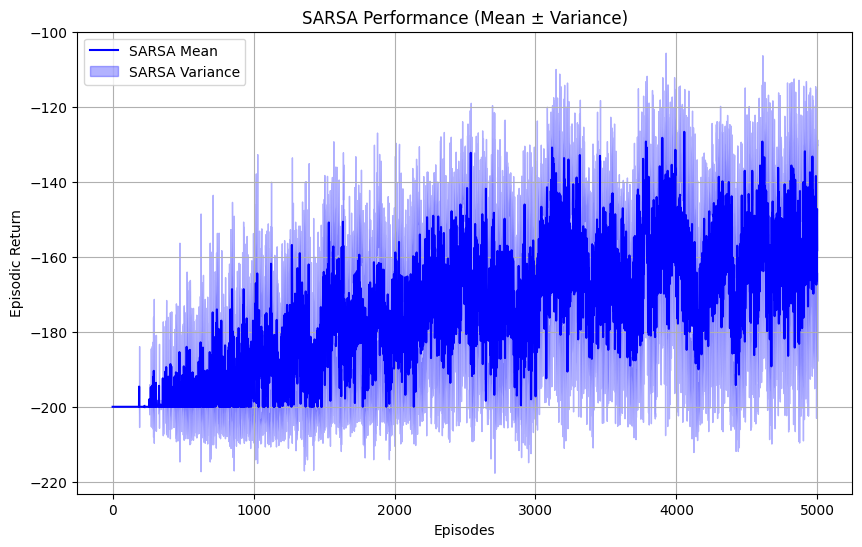

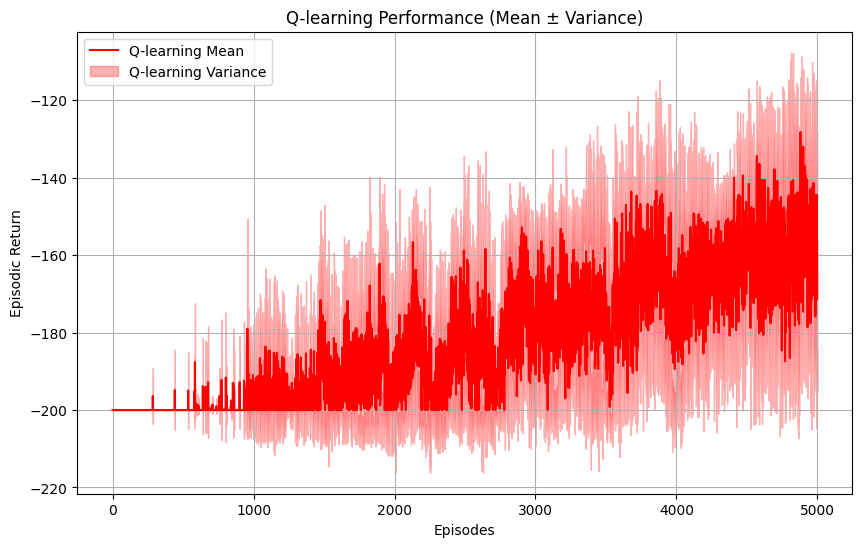

In [ ]:
best_sarsa_params = {
    "alpha": 0.15,
    "epsilon": 0.05,
    "num_bins": 15,
    "gamma": 0.99,
    "num_episodes": 5000,
    "max_steps": 200
}

best_q_params = {
    "alpha": 0.1,
    "temperature": 0.2,
    "num_bins": 20,
    "gamma": 0.99,
    "num_episodes": 5000,
    "max_steps": 200
}

# Plot SARSA results
plt.figure(figsize=(10, 6))
plt.plot(sarsa_mean, label='SARSA Mean', color='blue')
plt.fill_between(range(best_sarsa_params['num_episodes']),
                 sarsa_mean - sarsa_std,
                 sarsa_mean + sarsa_std,
                 alpha=0.3, color='blue', label='SARSA Variance')
plt.xlabel('Episodes')
plt.ylabel('Episodic Return')
plt.title('SARSA Performance (Mean ± Variance)')
plt.legend()
plt.grid()
plt.show()

# Plot Q-learning results
plt.figure(figsize=(10, 6))
plt.plot(q_learning_mean, label='Q-learning Mean', color='red')
plt.fill_between(range(best_q_params['num_episodes']),
                 q_learning_mean - q_learning_std,
                 q_learning_mean + q_learning_std,
                 alpha=0.3, color='red', label='Q-learning Variance')
plt.xlabel('Episodes')
plt.ylabel('Episodic Return')
plt.title('Q-learning Performance (Mean ± Variance)')
plt.legend()
plt.grid()
plt.show()